In [13]:
# 필요한 패키지 설치
%pip install pandas numpy matplotlib seaborn openpyxl scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
# 데이터 전처리를 위한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import os
from dotenv import load_dotenv

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# =========================
# DB 연결 및 저장 
# =========================

import sys
import os

# DB 폴더의 .env 파일을 명시적으로 로드
current_dir = os.path.dirname(os.path.abspath('dart_data.ipynb'))
parent_dir = os.path.dirname(current_dir)
db_folder = os.path.join(parent_dir, 'DB')
env_file_path = os.path.join(db_folder, '.env')

print(f"환경변수 파일 경로: {env_file_path}")
if os.path.exists(env_file_path):
    from dotenv import load_dotenv
    load_dotenv(env_file_path)
    print(f".env 파일 로드 성공")
    print(f"DB_PASSWORD 설정됨: {'YES' if os.getenv('DB_PASSWORD') else 'NO'}")
else:
    print(f".env 파일을 찾을 수 없습니다: {env_file_path}")

# DB 연결을 위한 경로 추가 및 import
try:
    # sys.path에 DB 폴더 추가
    if db_folder not in sys.path:
        sys.path.insert(0, db_folder)
        print(f"DB 폴더를 sys.path에 추가: {db_folder}")
    
    # 간단한 import 방식
    import db_query
    DatabaseConnection = db_query.DatabaseConnection
    print("db_query 모듈 import 성공")
    
except Exception as e:
    print(f"데이터베이스 모듈 import 실패: {e}")
    print("CSV 파일로만 저장됩니다.")
    DatabaseConnection = None

환경변수 파일 경로: c:\Users\baesh\Desktop\kor-ie-proj\DB\.env
.env 파일 로드 성공
DB_PASSWORD 설정됨: YES
DB 폴더를 sys.path에 추가: c:\Users\baesh\Desktop\kor-ie-proj\DB
db_query 모듈 import 성공


# 1. ECOS 경제 데이터 전처리

ECOS(한국은행 경제통계시스템)에서 수집한 경제 지표 데이터를 전처리합니다.

In [3]:
# ECOS 경제데이터를 MySQL에서 직접 로드
try:
    # 새로운 데이터베이스 연결 생성
    if DatabaseConnection is None:
        raise Exception("데이터베이스 모듈을 사용할 수 없습니다.")
    
    # 기존 연결이 있다면 닫기
    if 'db' in locals() and hasattr(db, 'connection') and db.connection:
        db.disconnect()
        print("기존 데이터베이스 연결을 닫았습니다.")
    
    # 새로운 연결 생성
    db = DatabaseConnection()
    if not db.connect():
        raise Exception("데이터베이스 연결에 실패했습니다.")
    
    print("데이터베이스 연결 성공!")
    
    # ECOS 데이터 조회
    ecos_data = db.get_ecos_data()
    
    if ecos_data is not None and not ecos_data.empty:
        print(f"ECOS 데이터 로드 완료: {ecos_data.shape}")
        
        # created_at, updated_at 컬럼 제거
        columns_to_remove = ['created_at', 'updated_at', 'id']
        existing_remove_cols = [col for col in columns_to_remove if col in ecos_data.columns]
        if existing_remove_cols:
            ecos_data = ecos_data.drop(columns=existing_remove_cols)
            print(f"불필요한 컬럼 제거: {existing_remove_cols}")
            print(f"컬럼 제거 후 데이터 형태: {ecos_data.shape}")
        
        # 수치형 컬럼의 데이터 타입 변환
        print("\n=== 데이터 타입 변환 ===")
        numeric_column_names = [col for col in ecos_data.columns if col != 'date']
        
        for col in numeric_column_names:
            try:
                # object 타입인 경우 숫자로 변환
                if ecos_data[col].dtype == 'object':
                    # 문자열에서 숫자로 변환 (errors='coerce'로 변환 불가능한 값은 NaN으로)
                    ecos_data[col] = pd.to_numeric(ecos_data[col], errors='coerce')
                    print(f"{col}: object → {ecos_data[col].dtype}")
            except Exception as e:
                print(f"{col} 변환 실패: {e}")
        
        print("\n컬럼 정보:")
        print(ecos_data.columns.tolist())
        print("\n데이터 미리보기:")
        print(ecos_data.head())
        
        print("\n=== ECOS 데이터 기본 정보 ===")
        print(f"데이터 형태: {ecos_data.shape}")
        print(f"메모리 사용량: {ecos_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        print("\n=== 데이터 타입 (변환 후) ===")
        print(ecos_data.dtypes)
        
        print("\n=== 결측값 확인 ===")
        print(ecos_data.isnull().sum())
        
        print("\n=== 수치형 컬럼 기본 통계 ===")
        numeric_cols_check = ecos_data.select_dtypes(include=[np.number]).columns
        if len(numeric_cols_check) > 0:
            print(ecos_data[numeric_cols_check].describe())
        else:
            print("변환 후에도 수치형 컬럼이 없습니다.")
    else:
        print("ECOS 데이터가 비어있거나 조회되지 않았습니다.")
        
except Exception as e:
    print(f"ECOS 데이터 로드 중 오류 발생: {e}")
    import traceback
    traceback.print_exc()

MySQL 데이터베이스 연결 성공
데이터베이스 연결 성공!
ECOS 데이터 로드 완료: (120, 23)
불필요한 컬럼 제거: ['created_at', 'updated_at', 'id']
컬럼 제거 후 데이터 형태: (120, 20)

=== 데이터 타입 변환 ===
base_rate: object → float64
ccsi: object → float64
construction_bsi_actual: object → float64
construction_bsi_forecast: object → float64
cpi: object → float64
esi: object → float64
exchange_usd_krw_close: object → float64
housing_lease_price: object → float64
housing_sale_price: object → float64
import_price_non_metal_mineral: object → float64
import_price_steel_primary: object → float64
leading_index: object → float64
m2_growth: object → float64
market_rate_treasury_bond_10yr: object → float64
market_rate_treasury_bond_3yr: object → float64
market_rate_corporate_bond_3yr_AA: object → float64
market_rate_corporate_bond_3yr_BBB: object → float64
ppi_non_metal_mineral: object → float64
ppi_steel_primary: object → float64

컬럼 정보:
['date', 'base_rate', 'ccsi', 'construction_bsi_actual', 'construction_bsi_forecast', 'cpi', 'esi', 'exchange_us

In [4]:
ecos_data.head()

,date,base_rate,ccsi,construction_bsi_actual,construction_bsi_forecast,cpi,esi,exchange_usd_krw_close,housing_lease_price,housing_sale_price,import_price_non_metal_mineral,import_price_steel_primary,leading_index,m2_growth,market_rate_treasury_bond_10yr,market_rate_treasury_bond_3yr,market_rate_corporate_bond_3yr_AA,market_rate_corporate_bond_3yr_BBB,ppi_non_metal_mineral,ppi_steel_primary
0,201510,1.5,92.0,73.0,72.0,94.966,97.5,1144.80,83.550,74.984,94.46,83.34,100.4,NaN,2.088,1.627,1.962,7.894,89.15,84.27
1,201511,1.5,92.0,69.0,72.0,94.786,97.1,1153.35,83.964,75.304,94.46,82.66,100.2,0.28,2.254,1.752,2.118,8.064,89.15,81.90
2,201512,1.5,91.0,69.0,70.0,95.070,94.0,1173.20,84.181,75.441,94.46,81.28,99.8,0.21,2.181,1.719,2.143,8.085,88.79,81.19
3,201601,1.5,90.0,67.0,69.0,95.232,93.9,1203.79,84.343,75.504,92.95,80.85,99.5,0.90,2.025,1.628,2.091,8.033,89.85,79.57
4,201602,1.5,90.0,63.0,67.0,95.640,92.8,1220.45,84.500,75.558,92.95,79.48,99.1,0.93,1.826,1.474,1.950,7.901,90.30,78.15


## ECOS 원본 데이터 시각화

주요 경제지표들의 시계열 변화를 시각화합니다.

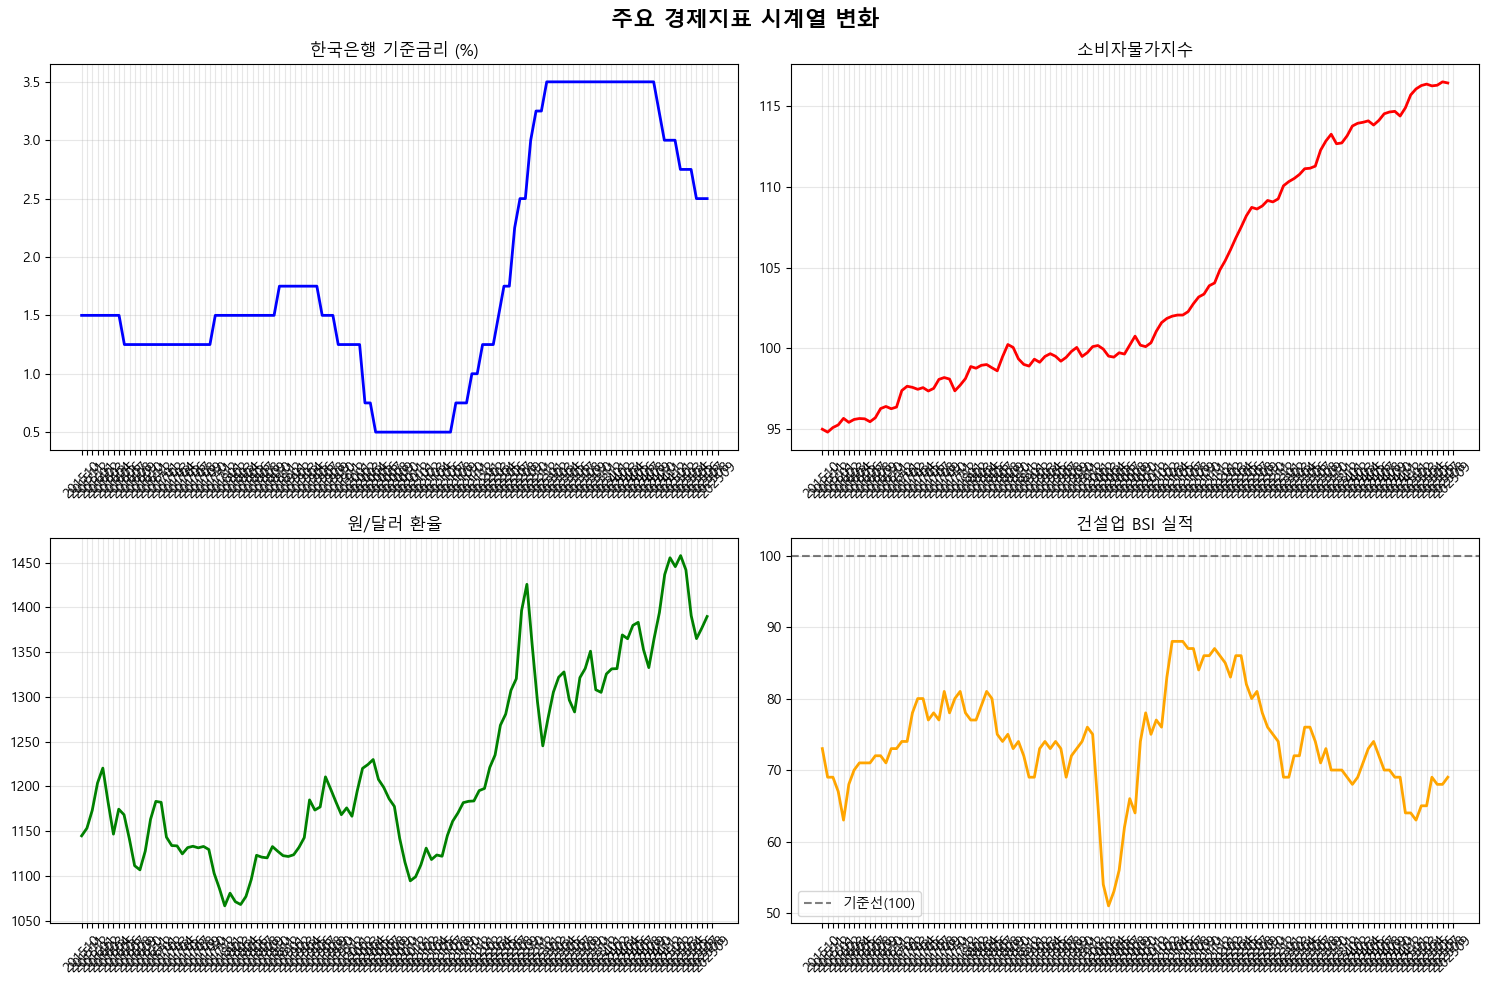

In [5]:
# 1. 주요 경제지표 시계열 그래프
if 'ecos_data' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('주요 경제지표 시계열 변화', fontsize=16, fontweight='bold')
    
    # 1) 기준금리
    axes[0, 0].plot(ecos_data['date'], ecos_data['base_rate'], color='blue', linewidth=2)
    axes[0, 0].set_title('한국은행 기준금리 (%)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2) 소비자물가지수
    axes[0, 1].plot(ecos_data['date'], ecos_data['cpi'], color='red', linewidth=2)
    axes[0, 1].set_title('소비자물가지수')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3) 원달러 환율
    axes[1, 0].plot(ecos_data['date'], ecos_data['exchange_usd_krw_close'], color='green', linewidth=2)
    axes[1, 0].set_title('원/달러 환율')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4) 건설업 BSI 실적
    axes[1, 1].plot(ecos_data['date'], ecos_data['construction_bsi_actual'], color='orange', linewidth=2)
    axes[1, 1].set_title('건설업 BSI 실적')
    axes[1, 1].axhline(y=100, color='black', linestyle='--', alpha=0.5, label='기준선(100)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("ECOS 데이터가 없습니다. 이전 셀을 먼저 실행해주세요.")

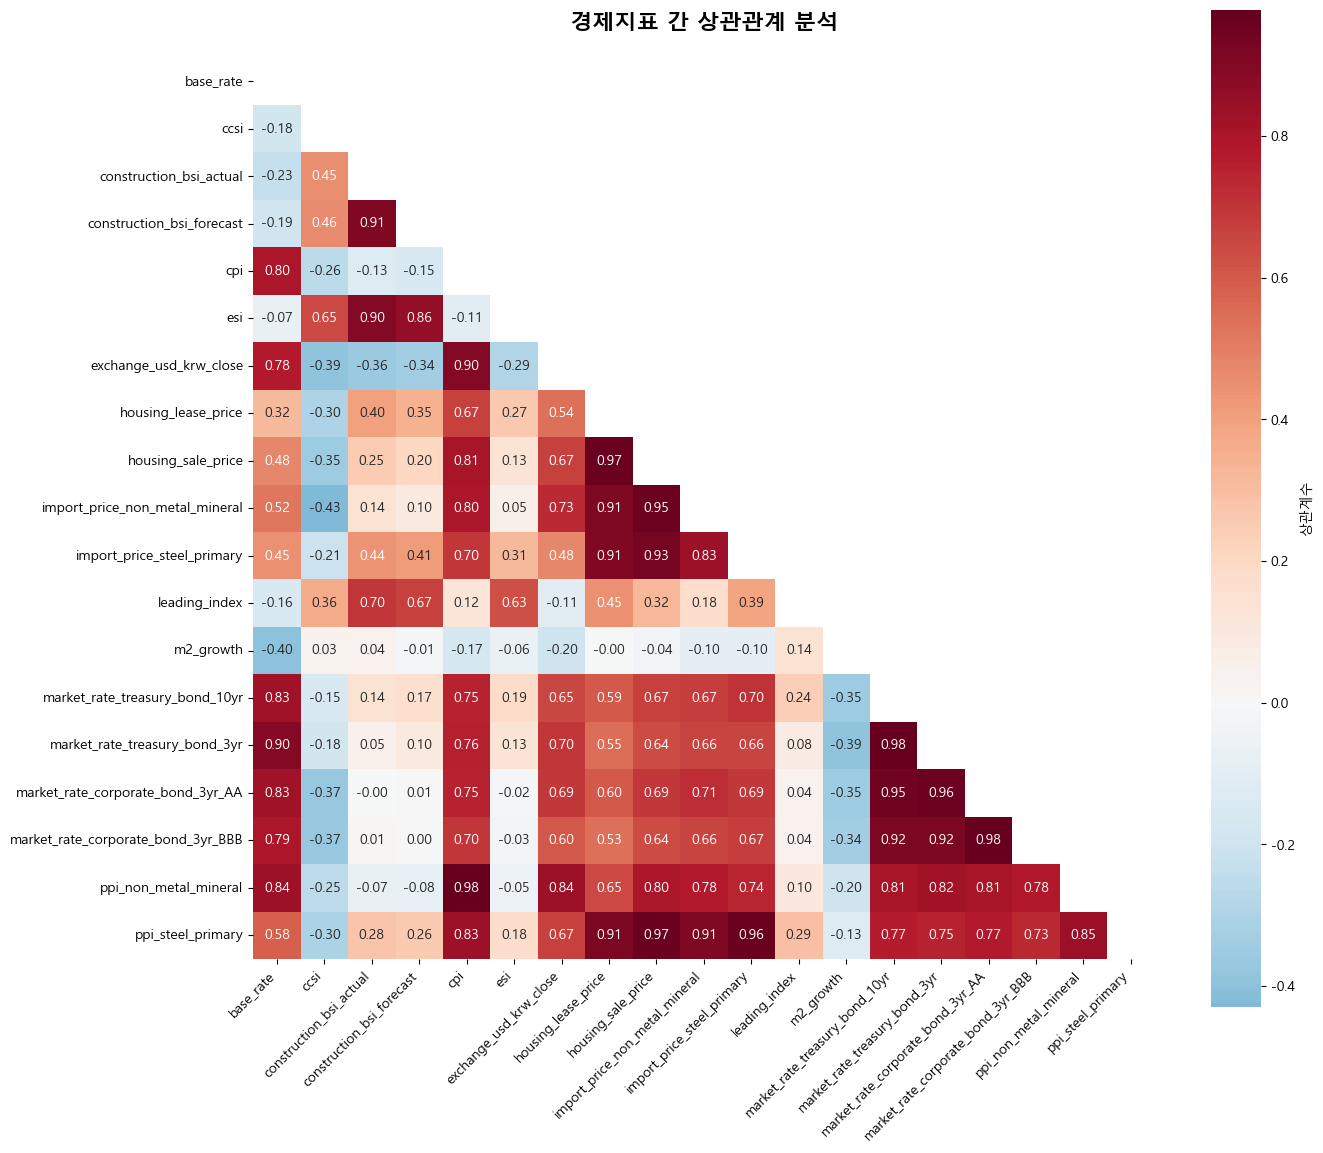

=== 건설업 BSI 실적과의 상관관계 ===
construction_bsi_actual       1.000000
construction_bsi_forecast     0.912037
esi                           0.895433
leading_index                 0.701876
ccsi                          0.451163
import_price_steel_primary    0.444805
housing_lease_price           0.399952
exchange_usd_krw_close        0.360765
ppi_steel_primary             0.277672
housing_sale_price            0.252087
Name: construction_bsi_actual, dtype: float64


In [6]:
# 2. 경제지표 간 상관관계 히트맵
if 'ecos_data' in locals():
    # 수치형 컬럼만 선택 (날짜 제외)
    numeric_cols = ecos_data.select_dtypes(include=[np.number]).columns
    correlation_matrix = ecos_data[numeric_cols].corr()
    
    plt.figure(figsize=(14, 12))
    
    # 히트맵 생성
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # 상삼각 마스크
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={'label': '상관계수'})
    
    plt.title('경제지표 간 상관관계 분석', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # 건설업 BSI와 높은 상관관계를 가진 지표들
    print("=== 건설업 BSI 실적과의 상관관계 ===")
    bsi_corr = correlation_matrix['construction_bsi_actual'].abs().sort_values(ascending=False)
    print(bsi_corr.head(10))

In [7]:
import numpy as np
import pandas as pd

def create_quarterly_data(df, current_date=None):
    """
    월간 데이터를 분기별 데이터로 변환하고 파생변수를 생성 
    
    Parameters:
    df: ECOS 월간 데이터프레임
    current_date: 현재 날짜 
    
    Returns:
    quarterly_df: 분기별 데이터프레임 (파생변수 포함, year, quarter만 포함)
    """
    # 1. 날짜 컬럼을 datetime으로 변환 (YYYYMM 형식 처리)
    df = df.copy()
    # YYYYMM 형식을 YYYY-MM-01 형식으로 변환
    df['date'] = pd.to_datetime(df['date'].astype(str) + '01', format='%Y%m%d')
    df = df.sort_values('date').reset_index(drop=True)
    
    # 현재 날짜 기준으로 데이터 필터링 (월말 기준)
    if current_date is None:
        current_date = pd.Timestamp.now()
    else:
        current_date = pd.to_datetime(current_date)
    current_year = current_date.year
    current_month = current_date.month
    
    # 현재 월이 완료되지 않았으므로 이전 월까지만 사용
    if current_month > 1:
        cutoff_date = pd.Timestamp(current_year, current_month - 1, 1)
    else:
        cutoff_date = pd.Timestamp(current_year - 1, 12, 1)
    
    print(f"데이터 필터링: {cutoff_date.strftime('%Y-%m')}월까지 사용")
    df = df[df['date'] <= cutoff_date]
    
    # 2. year, quarter 컬럼 추가
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    # 분기 매핑: 1-3월=Q1, 4-6월=Q2, 7-9월=Q3, 10-12월=Q4
    def get_quarter(month):
        if month in [1, 2, 3]:
            return 'Q1'
        elif month in [4, 5, 6]:
            return 'Q2'
        elif month in [7, 8, 9]:
            return 'Q3'
        else:  # 10, 11, 12
            return 'Q4'
    
    df['quarter'] = df['month'].apply(get_quarter)
    
    # 3. 분기별 그룹핑 및 집계 (3개월 평균) - 모든 수치형 컬럼 포함
    # date, year, month, quarter 제외한 모든 컬럼을 집계
    exclude_cols = ['date', 'year', 'month', 'quarter']
    numeric_cols = [col for col in df.columns if col not in exclude_cols]
    
    # 모든 수치형 컬럼에 대해 평균 계산
    agg_dict = {col: 'mean' for col in numeric_cols}
    
    quarterly_df = df.groupby(['year', 'quarter']).agg(agg_dict).reset_index()
    
    # 4. 분기별 데이터 필터링 (3개월 데이터가 모두 있는 분기만 포함)
    # 각 분기별로 원본 데이터 개수 확인
    quarter_counts = df.groupby(['year', 'quarter']).size().reset_index(name='month_count')
    complete_quarters = quarter_counts[quarter_counts['month_count'] == 3]
    
    print(f"완전한 분기 데이터 (3개월 모두 있는 분기): {len(complete_quarters)}개")
    if len(quarter_counts) > len(complete_quarters):
        incomplete_quarters = quarter_counts[quarter_counts['month_count'] < 3]
        print(f"불완전한 분기 데이터 (제외됨):")
        for _, row in incomplete_quarters.iterrows():
            print(f"  {row['year']}년 {row['quarter']}: {row['month_count']}개월만 있음")
    
    # 완전한 분기 데이터만 선택
    quarterly_df = quarterly_df.merge(complete_quarters[['year', 'quarter']], 
                                    on=['year', 'quarter'], how='inner')
    
    # 5. 파생변수 생성
    
    # 5-1. CPI QoQ (Quarter over Quarter) 변화율
    quarterly_df = quarterly_df.sort_values(['year', 'quarter']).reset_index(drop=True)
    quarterly_df['cpi_qoq'] = quarterly_df['cpi'].pct_change() * 100  # 백분율로 변환
    
    # 5-2. 환율 분기 표준편차 (분기 내 변동성)
    exchange_std = df.groupby(['year', 'quarter'])['exchange_usd_krw_close'].std().reset_index()
    exchange_std.columns = ['year', 'quarter', 'exchange_qstd']
    quarterly_df = quarterly_df.merge(exchange_std, on=['year', 'quarter'], how='left')
    
    # 5-3. Term Spread (10Y - 3Y 국고채 금리차)
    quarterly_df['term_spread'] = quarterly_df['market_rate_treasury_bond_10yr'] - quarterly_df['market_rate_treasury_bond_3yr']
    
    # 5-4. Credit Spread (BBB - AA 회사채 금리차)
    quarterly_df['credit_spread'] = quarterly_df['market_rate_corporate_bond_3yr_BBB'] - quarterly_df['market_rate_corporate_bond_3yr_AA']
    
    # 5-5. 기준금리 분기별 변화폭 (bp, basis points)
    quarterly_df['base_rate_qdiff_bp'] = quarterly_df['base_rate'].diff() * 100  # bp로 변환
    
    # 6. QoQ 계산으로 인한 첫 번째 분기 제거 (2016 Q1부터 시작)
    quarterly_df = quarterly_df.dropna(subset=['cpi_qoq']).reset_index(drop=True)
    
    # 7. 컬럼 순서 정리 - 파생변수를 해당 지표 옆에 배치
    # 기본 컬럼들
    base_time_cols = ['year', 'quarter']
    
    # 모든 파생변수 리스트
    all_derived_cols = ['cpi_qoq', 'exchange_qstd', 'term_spread', 'credit_spread', 'base_rate_qdiff_bp']
    
    # 원본 경제지표 컬럼들 (파생변수와 시간 컬럼 제외)
    original_ecos_cols = [col for col in quarterly_df.columns 
                         if col not in base_time_cols + all_derived_cols]
    
    # 컬럼 순서: 지표와 관련 파생변수를 그룹으로 배치
    column_order = base_time_cols.copy()
    
    # 기준금리 그룹 (base_rate + base_rate_qdiff_bp)
    if 'base_rate' in original_ecos_cols:
        column_order.append('base_rate')
        if 'base_rate_qdiff_bp' in quarterly_df.columns:
            column_order.append('base_rate_qdiff_bp')
        original_ecos_cols.remove('base_rate')
    
    # CPI 그룹 (cpi + cpi_qoq)  
    if 'cpi' in original_ecos_cols:
        column_order.append('cpi')
        if 'cpi_qoq' in quarterly_df.columns:
            column_order.append('cpi_qoq')
        original_ecos_cols.remove('cpi')
    
    # 환율 그룹 (exchange_usd_krw_close + exchange_qstd)
    if 'exchange_usd_krw_close' in original_ecos_cols:
        column_order.append('exchange_usd_krw_close')
        if 'exchange_qstd' in quarterly_df.columns:
            column_order.append('exchange_qstd')
        original_ecos_cols.remove('exchange_usd_krw_close')
    
    # 국고채 3년 그룹
    if 'market_rate_treasury_bond_3yr' in original_ecos_cols:
        column_order.append('market_rate_treasury_bond_3yr')
        original_ecos_cols.remove('market_rate_treasury_bond_3yr')
    
    # 국고채 10년 그룹
    if 'market_rate_treasury_bond_10yr' in original_ecos_cols:
        column_order.append('market_rate_treasury_bond_10yr')
        original_ecos_cols.remove('market_rate_treasury_bond_10yr')
    
    # Term Spread (10Y - 3Y 국고채 금리차)
    if 'term_spread' in quarterly_df.columns:
        column_order.append('term_spread')
    
    # 회사채 AA 그룹
    if 'market_rate_corporate_bond_3yr_AA' in original_ecos_cols:
        column_order.append('market_rate_corporate_bond_3yr_AA')
        original_ecos_cols.remove('market_rate_corporate_bond_3yr_AA')
    
    # 회사채 BBB 그룹
    if 'market_rate_corporate_bond_3yr_BBB' in original_ecos_cols:
        column_order.append('market_rate_corporate_bond_3yr_BBB')
        original_ecos_cols.remove('market_rate_corporate_bond_3yr_BBB')
    
    # Credit Spread (BBB - AA 회사채 금리차)
    if 'credit_spread' in quarterly_df.columns:
        column_order.append('credit_spread')
    
    # 나머지 원본 경제지표들 (알파벳 순서)
    remaining_cols = sorted(original_ecos_cols)
    column_order.extend(remaining_cols)
    
    # 실제 존재하는 컬럼만 선택
    final_columns = [col for col in column_order if col in quarterly_df.columns]
    quarterly_df = quarterly_df[final_columns]
    
    return quarterly_df

# ECOS 분기별 데이터 생성
print("=== ECOS 데이터 분기별 변환 시작 ===")
print(f"원본 데이터 기간: {ecos_data['date'].min()} ~ {ecos_data['date'].max()}")
print(f"원본 데이터 개수: {len(ecos_data)}개")

# 현재 날짜 기준으로 분기별 변환 (9월 데이터 제외)
ecos_quarterly = create_quarterly_data(ecos_data, current_date=None)

print(f"\n분기별 데이터 기간: {ecos_quarterly['year'].min()}년 {ecos_quarterly['quarter'].iloc[0]} ~ {ecos_quarterly['year'].max()}년 {ecos_quarterly['quarter'].iloc[-1]}")
print(f"분기별 데이터 개수: {len(ecos_quarterly)}개")

# 파생변수 요약 통계
print("\n=== 파생변수 요약 통계 ===")
derived_vars = ['cpi_qoq', 'exchange_qstd', 'term_spread', 'credit_spread', 'base_rate_qdiff_bp']
print(ecos_quarterly[derived_vars].describe().round(2))

# 최근 5개 분기 데이터 확인
print("\n=== 최근 5개 분기 데이터 ===")
recent_cols = ['year', 'quarter', 'cpi_qoq', 'exchange_qstd', 'term_spread', 'credit_spread', 'base_rate_qdiff_bp']
print(ecos_quarterly[recent_cols].tail())

# 전체 분기별 데이터 샘플 확인
print("\n=== 분기별 데이터 샘플 (처음 3개, 마지막 3개) ===")
print("처음 3개 분기:")
print(ecos_quarterly[recent_cols].head(3))
print("\n마지막 3개 분기:")
print(ecos_quarterly[recent_cols].tail(3))

# 최종 데이터 컬럼 확인
print(f"\n=== 최종 분기별 데이터 컬럼 ===")
print(f"총 컬럼 수: {len(ecos_quarterly.columns)}")
print("컬럼 목록:")
for i, col in enumerate(ecos_quarterly.columns):
    print(f"  {i+1}. {col}")

=== ECOS 데이터 분기별 변환 시작 ===
원본 데이터 기간: 201510 ~ 202509
원본 데이터 개수: 120개
데이터 필터링: 2025-08월까지 사용
완전한 분기 데이터 (3개월 모두 있는 분기): 39개
불완전한 분기 데이터 (제외됨):
  2025년 Q3: 2개월만 있음

분기별 데이터 기간: 2016년 Q1 ~ 2025년 Q2
분기별 데이터 개수: 38개

=== 파생변수 요약 통계 ===
       cpi_qoq  exchange_qstd  term_spread  credit_spread  base_rate_qdiff_bp
count    38.00          38.00        38.00          38.00               38.00
mean      0.54          18.06         0.32           6.13                2.85
std       0.53          13.81         0.22           0.20               25.43
min      -0.51           0.95        -0.03           5.76              -50.00
25%       0.21           7.01         0.14           5.99               -6.25
50%       0.49          16.39         0.32           6.15                0.00
75%       0.83          25.55         0.48           6.28                8.33
max       1.95          65.72         0.90           6.41               75.00

=== 최근 5개 분기 데이터 ===
    year quarter   cpi_qoq  exchange_qstd  t

In [8]:
ecos_quarterly.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   year                                38 non-null     int32  
 1   quarter                             38 non-null     object 
 2   base_rate                           38 non-null     float64
 3   base_rate_qdiff_bp                  38 non-null     float64
 4   cpi                                 38 non-null     float64
 5   cpi_qoq                             38 non-null     float64
 6   exchange_usd_krw_close              38 non-null     float64
 7   exchange_qstd                       38 non-null     float64
 8   market_rate_treasury_bond_3yr       38 non-null     float64
 9   market_rate_treasury_bond_10yr      38 non-null     float64
 10  term_spread                         38 non-null     float64
 11  market_rate_corporate_bond_3yr_AA   38 non-null

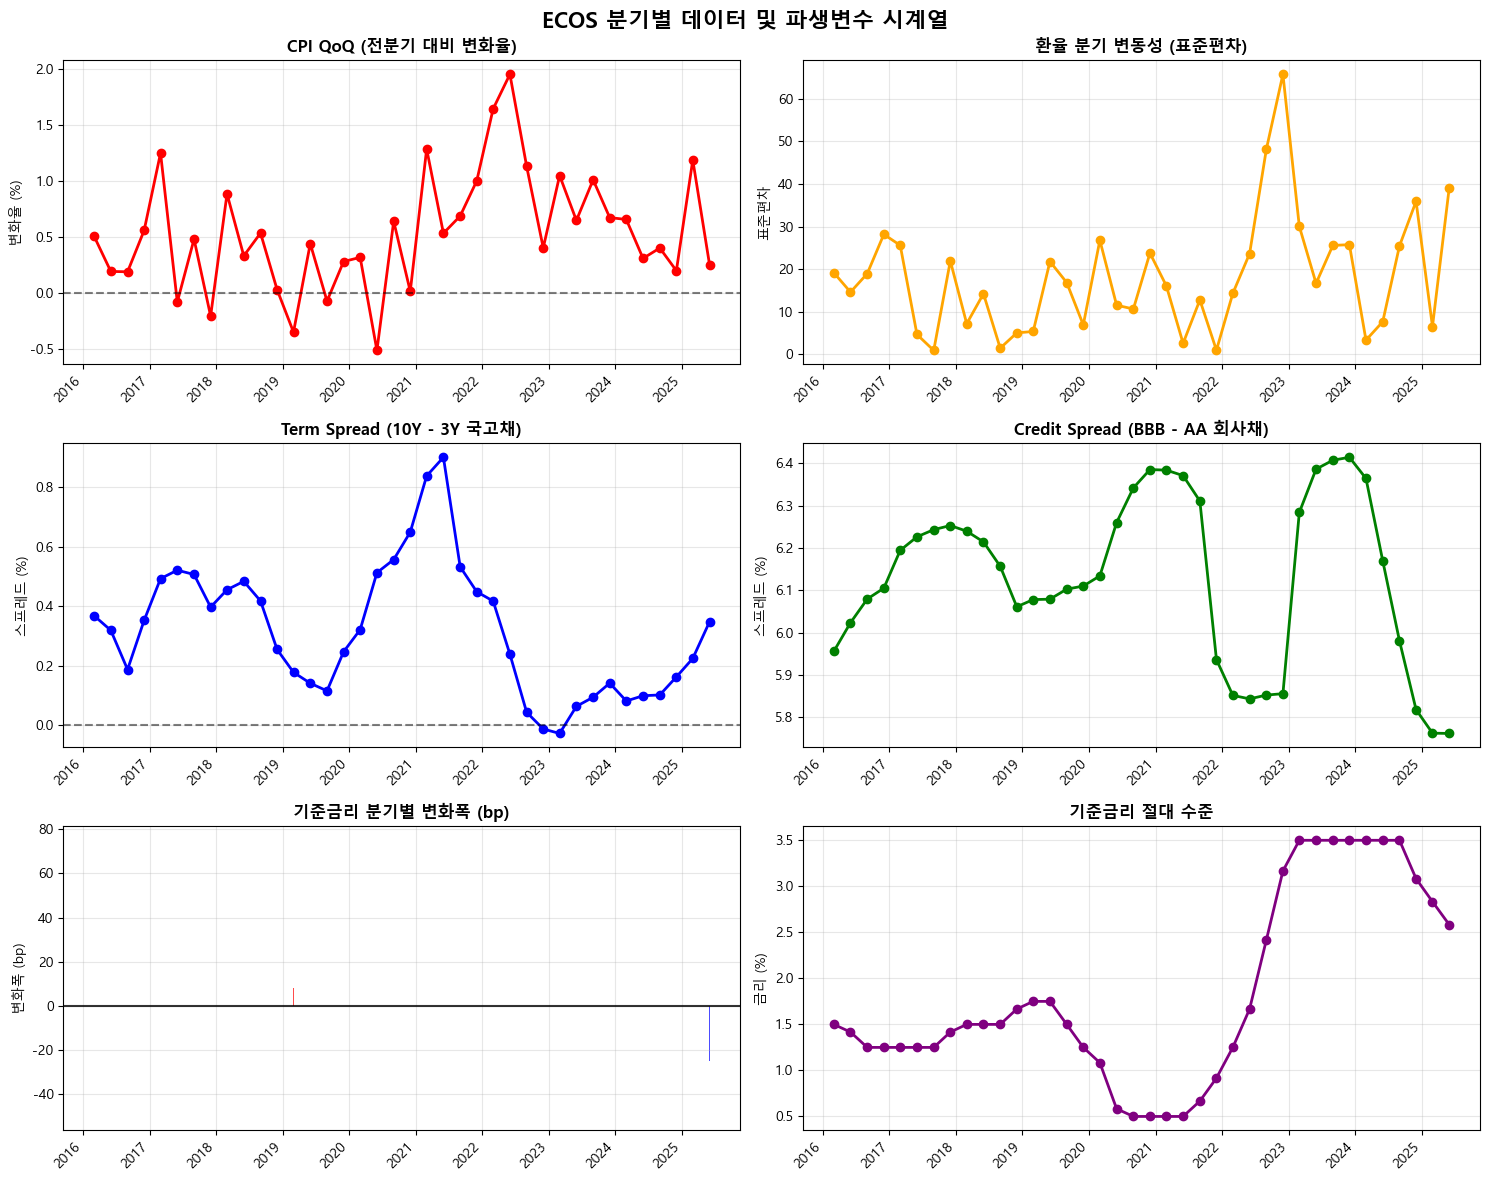


=== 파생변수 간 상관관계 ===
                    cpi_qoq  exchange_qstd  term_spread  credit_spread  \
cpi_qoq               1.000          0.103        0.002         -0.155   
exchange_qstd         0.103          1.000       -0.423         -0.355   
term_spread           0.002         -0.423        1.000          0.331   
credit_spread        -0.155         -0.355        0.331          1.000   
base_rate_qdiff_bp    0.454          0.389       -0.215         -0.173   

                    base_rate_qdiff_bp  
cpi_qoq                          0.454  
exchange_qstd                    0.389  
term_spread                     -0.215  
credit_spread                   -0.173  
base_rate_qdiff_bp               1.000  

=== 연도별 파생변수 평균 (최근 5년) ===
      cpi_qoq  exchange_qstd  term_spread  credit_spread  base_rate_qdiff_bp
year                                                                        
2020     0.11          18.20         0.51           6.28              -18.75
2021     0.88           8.13

In [9]:
# 분기별 데이터 및 파생변수 시각화
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 분기별 날짜 생성 (시각화용) - year와 quarter로부터 생성
def quarter_to_month(quarter):
    return {'Q1': 3, 'Q2': 6, 'Q3': 9, 'Q4': 12}[quarter]

ecos_quarterly['quarter_date'] = pd.to_datetime(
    ecos_quarterly['year'].astype(str) + '-' + 
    ecos_quarterly['quarter'].apply(quarter_to_month).astype(str) + '-01'
)

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('ECOS 분기별 데이터 및 파생변수 시계열', fontsize=16, fontweight='bold')

# 1. CPI QoQ
axes[0,0].plot(ecos_quarterly['quarter_date'], ecos_quarterly['cpi_qoq'], 'o-', color='red', linewidth=2)
axes[0,0].set_title('CPI QoQ (전분기 대비 변화율)', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('변화율 (%)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 2. 환율 표준편차
axes[0,1].plot(ecos_quarterly['quarter_date'], ecos_quarterly['exchange_qstd'], 'o-', color='orange', linewidth=2)
axes[0,1].set_title('환율 분기 변동성 (표준편차)', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('표준편차')
axes[0,1].grid(True, alpha=0.3)

# 3. Term Spread
axes[1,0].plot(ecos_quarterly['quarter_date'], ecos_quarterly['term_spread'], 'o-', color='blue', linewidth=2)
axes[1,0].set_title('Term Spread (10Y - 3Y 국고채)', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('스프레드 (%)')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 4. Credit Spread
axes[1,1].plot(ecos_quarterly['quarter_date'], ecos_quarterly['credit_spread'], 'o-', color='green', linewidth=2)
axes[1,1].set_title('Credit Spread (BBB - AA 회사채)', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('스프레드 (%)')
axes[1,1].grid(True, alpha=0.3)

# 5. 기준금리 변화폭
axes[2,0].bar(ecos_quarterly['quarter_date'], ecos_quarterly['base_rate_qdiff_bp'], 
              color=['red' if x > 0 else 'blue' for x in ecos_quarterly['base_rate_qdiff_bp']], alpha=0.7)
axes[2,0].set_title('기준금리 분기별 변화폭 (bp)', fontsize=12, fontweight='bold')
axes[2,0].set_ylabel('변화폭 (bp)')
axes[2,0].grid(True, alpha=0.3)
axes[2,0].axhline(y=0, color='black', linestyle='-', alpha=0.8)

# 6. 기준금리 절대수준
axes[2,1].plot(ecos_quarterly['quarter_date'], ecos_quarterly['base_rate'], 'o-', color='purple', linewidth=2)
axes[2,1].set_title('기준금리 절대 수준', fontsize=12, fontweight='bold')
axes[2,1].set_ylabel('금리 (%)')
axes[2,1].grid(True, alpha=0.3)

# X축 날짜 포맷팅 (연도만 표시)
for ax in axes.flat:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 분기별 데이터 상관관계 분석
print("\n=== 파생변수 간 상관관계 ===")
correlation_matrix = ecos_quarterly[derived_vars].corr()
print(correlation_matrix.round(3))

# 분기별 요약 통계 (년도별)
print("\n=== 연도별 파생변수 평균 (최근 5년) ===")
recent_years = ecos_quarterly[ecos_quarterly['year'] >= 2020].groupby('year')[derived_vars].mean()
print(recent_years.round(2))

# 최종 데이터 확인 (date 컬럼 제거됨 확인)
print(f"\n=== 최종 분기별 데이터 구조 ===")
print(f"데이터 형태: {ecos_quarterly.shape}")
print(f"컬럼 목록: {list(ecos_quarterly.columns)}")
print(f"date 컬럼 포함 여부: {'date' in ecos_quarterly.columns}")
print(f"quarter_date 컬럼 포함 여부 (시각화용): {'quarter_date' in ecos_quarterly.columns}")

# quarter_date 컬럼은 시각화용이므로 제거 (필요시)
if 'quarter_date' in ecos_quarterly.columns:
    ecos_quarterly_clean = ecos_quarterly.drop(columns=['quarter_date'])
    print(f"\n시각화용 quarter_date 컬럼 제거 후 형태: {ecos_quarterly_clean.shape}")
    print(f"최종 클린 데이터 컬럼: {list(ecos_quarterly_clean.columns)}")
    
    # 클린 데이터를 ecos_quarterly로 업데이트
    ecos_quarterly = ecos_quarterly_clean

In [10]:
ecos_quarterly

,year,quarter,base_rate,base_rate_qdiff_bp,cpi,cpi_qoq,exchange_usd_krw_close,exchange_qstd,market_rate_treasury_bond_3yr,market_rate_treasury_bond_10yr,...,construction_bsi_forecast,esi,housing_lease_price,housing_sale_price,import_price_non_metal_mineral,import_price_steel_primary,leading_index,m2_growth,ppi_non_metal_mineral,ppi_steel_primary
0,2016,Q1,1.500000,0.000000,95.421667,0.506632,1202.130000,19.203885,1.533333,1.901667,...,67.666667,93.700000,84.489333,75.548667,91.730000,80.250000,99.266667,0.730000,90.403333,78.680000
1,2016,Q2,1.416667,-8.333333,95.604667,0.191780,1163.216667,14.629581,1.419000,1.738000,...,73.000000,95.866667,84.809000,75.671333,84.060000,81.830000,99.266667,0.576667,91.976667,81.956667
2,2016,Q3,1.250000,-16.666667,95.785000,0.188624,1119.963333,18.967542,1.256000,1.443333,...,72.666667,97.466667,85.062333,75.930000,82.843333,83.673333,99.500000,0.670000,93.903333,83.913333
3,2016,Q4,1.250000,0.000000,96.319333,0.557847,1158.056667,28.182009,1.554000,1.906667,...,73.000000,95.666667,85.422000,76.361667,79.353333,87.726667,100.100000,0.360000,94.666667,85.900000
4,2017,Q1,1.250000,0.000000,97.521000,1.247586,1153.183333,25.599891,1.672333,2.165000,...,75.333333,98.433333,85.563667,76.493000,74.310000,94.460000,100.700000,0.363333,95.623333,96.983333
5,2017,Q2,1.250000,0.000000,97.442000,-0.081008,1129.946667,4.689524,1.680333,2.201333,...,81.333333,100.766667,85.634333,76.609000,74.383333,96.246667,101.333333,0.486667,96.400000,95.873333
6,2017,Q3,1.250000,0.000000,97.909667,0.479944,1132.486667,0.946379,1.768333,2.275000,...,78.666667,100.233333,85.791000,77.034667,70.353333,99.820000,101.733333,0.330000,96.586667,95.030000
7,2017,Q4,1.416667,16.666667,97.707333,-0.206653,1106.083333,21.947716,2.092000,2.489000,...,80.333333,102.766667,85.893333,77.323000,70.043333,105.530000,101.600000,0.416667,99.380000,99.966667
8,2018,Q1,1.500000,8.333333,98.570667,0.883591,1072.816667,7.215430,2.246000,2.701333,...,79.666667,100.033333,85.924000,77.732000,70.193333,109.763333,101.433333,0.686667,101.376667,100.406667
9,2018,Q2,1.500000,0.000000,98.896333,0.330389,1080.353333,14.245211,2.205667,2.689333,...,80.666667,101.166667,85.856333,78.126333,71.716667,111.993333,101.066667,0.540000,102.606667,101.610000


## ECOS 데이터 스케일링

데이터 분할 이후 수행

In [136]:
''' # StandardScaler를 사용한 분기별 데이터 스케일링
from sklearn.preprocessing import StandardScaler
import pandas as pd

if 'ecos_quarterly' in locals():
    print("=== ECOS 분기별 데이터 스케일링 ===")
    
    # year, quarter 컬럼 분리
    year_col = ecos_quarterly['year'].copy()
    quarter_col = ecos_quarterly['quarter'].copy()
    
    # 수치형 컬럼만 선택 (year, quarter 제외)
    numeric_cols = [col for col in ecos_quarterly.columns if col not in ['year', 'quarter']]
    numeric_data = ecos_quarterly[numeric_cols].copy()
    
    print(f"스케일링 대상 컬럼: {len(numeric_cols)}개")
    print(f"컬럼명: {list(numeric_cols)}")
    
    # 결측값 확인
    print(f"\n결측값 현황:")
    missing_counts = numeric_data.isnull().sum()
    print(missing_counts[missing_counts > 0])
    
    # 결측값이 있다면 처리 (forward fill 사용)
    if numeric_data.isnull().any().any():
        print("\n결측값을 forward fill로 처리합니다.")
        numeric_data = numeric_data.fillna(method='ffill')
        
        # 여전히 결측값이 있다면 backward fill
        if numeric_data.isnull().any().any():
            numeric_data = numeric_data.fillna(method='bfill')
    
    # StandardScaler 적용
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_data)
    
    # 스케일링된 데이터를 DataFrame으로 변환
    ecos_quarterly_scaled = pd.DataFrame(scaled_data, columns=numeric_cols, index=numeric_data.index)
    
    # year, quarter 컬럼 추가
    ecos_quarterly_scaled.insert(0, 'year', year_col)
    ecos_quarterly_scaled.insert(1, 'quarter', quarter_col)
    
    print(f"\n스케일링 완료!")
    print(f"원본 데이터 통계:")
    print(numeric_data.describe().round(2))
    print(f"\n스케일링 후 데이터 통계:")
    print(ecos_quarterly_scaled.select_dtypes(include=[np.number]).describe().round(2))
    
    # 스케일링 전후 비교 시각화
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 원본 데이터 분포
    numeric_data.boxplot(ax=axes[0], rot=45)
    axes[0].set_title('스케일링 전 분기별 데이터 분포')
    axes[0].set_ylabel('값')
    
    # 스케일링 후 데이터 분포 (year 제외)
    scaled_viz_cols = [col for col in ecos_quarterly_scaled.select_dtypes(include=[np.number]).columns if col != 'year']
    ecos_quarterly_scaled[scaled_viz_cols].boxplot(ax=axes[1], rot=45)
    axes[1].set_title('스케일링 후 분기별 데이터 분포')
    axes[1].set_ylabel('표준화된 값')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n스케일링된 분기별 데이터 형태: {ecos_quarterly_scaled.shape}")
    print("스케일링된 분기별 데이터를 'ecos_quarterly_scaled' 변수에 저장했습니다.")
    
    # 분기별 데이터 샘플 출력
    print(f"\n=== 스케일링된 분기별 데이터 샘플 ===")
    print("처음 5개 분기:")
    print(ecos_quarterly_scaled.head())
    print("\n마지막 5개 분기:")
    print(ecos_quarterly_scaled.tail())
    
else:
    print("ecos_quarterly 데이터가 없습니다. 분기별 데이터 변환 셀을 먼저 실행해주세요.") '''

' # StandardScaler를 사용한 분기별 데이터 스케일링\nfrom sklearn.preprocessing import StandardScaler\nimport pandas as pd\n\nif \'ecos_quarterly\' in locals():\n    print("=== ECOS 분기별 데이터 스케일링 ===")\n\n    # year, quarter 컬럼 분리\n    year_col = ecos_quarterly[\'year\'].copy()\n    quarter_col = ecos_quarterly[\'quarter\'].copy()\n\n    # 수치형 컬럼만 선택 (year, quarter 제외)\n    numeric_cols = [col for col in ecos_quarterly.columns if col not in [\'year\', \'quarter\']]\n    numeric_data = ecos_quarterly[numeric_cols].copy()\n\n    print(f"스케일링 대상 컬럼: {len(numeric_cols)}개")\n    print(f"컬럼명: {list(numeric_cols)}")\n\n    # 결측값 확인\n    print(f"\n결측값 현황:")\n    missing_counts = numeric_data.isnull().sum()\n    print(missing_counts[missing_counts > 0])\n\n    # 결측값이 있다면 처리 (forward fill 사용)\n    if numeric_data.isnull().any().any():\n        print("\n결측값을 forward fill로 처리합니다.")\n        numeric_data = numeric_data.fillna(method=\'ffill\')\n\n        # 여전히 결측값이 있다면 backward fill\n        if numeric_data.isnull

In [11]:
ecos_quarterly

,year,quarter,base_rate,base_rate_qdiff_bp,cpi,cpi_qoq,exchange_usd_krw_close,exchange_qstd,market_rate_treasury_bond_3yr,market_rate_treasury_bond_10yr,...,construction_bsi_forecast,esi,housing_lease_price,housing_sale_price,import_price_non_metal_mineral,import_price_steel_primary,leading_index,m2_growth,ppi_non_metal_mineral,ppi_steel_primary
0,2016,Q1,1.500000,0.000000,95.421667,0.506632,1202.130000,19.203885,1.533333,1.901667,...,67.666667,93.700000,84.489333,75.548667,91.730000,80.250000,99.266667,0.730000,90.403333,78.680000
1,2016,Q2,1.416667,-8.333333,95.604667,0.191780,1163.216667,14.629581,1.419000,1.738000,...,73.000000,95.866667,84.809000,75.671333,84.060000,81.830000,99.266667,0.576667,91.976667,81.956667
2,2016,Q3,1.250000,-16.666667,95.785000,0.188624,1119.963333,18.967542,1.256000,1.443333,...,72.666667,97.466667,85.062333,75.930000,82.843333,83.673333,99.500000,0.670000,93.903333,83.913333
3,2016,Q4,1.250000,0.000000,96.319333,0.557847,1158.056667,28.182009,1.554000,1.906667,...,73.000000,95.666667,85.422000,76.361667,79.353333,87.726667,100.100000,0.360000,94.666667,85.900000
4,2017,Q1,1.250000,0.000000,97.521000,1.247586,1153.183333,25.599891,1.672333,2.165000,...,75.333333,98.433333,85.563667,76.493000,74.310000,94.460000,100.700000,0.363333,95.623333,96.983333
5,2017,Q2,1.250000,0.000000,97.442000,-0.081008,1129.946667,4.689524,1.680333,2.201333,...,81.333333,100.766667,85.634333,76.609000,74.383333,96.246667,101.333333,0.486667,96.400000,95.873333
6,2017,Q3,1.250000,0.000000,97.909667,0.479944,1132.486667,0.946379,1.768333,2.275000,...,78.666667,100.233333,85.791000,77.034667,70.353333,99.820000,101.733333,0.330000,96.586667,95.030000
7,2017,Q4,1.416667,16.666667,97.707333,-0.206653,1106.083333,21.947716,2.092000,2.489000,...,80.333333,102.766667,85.893333,77.323000,70.043333,105.530000,101.600000,0.416667,99.380000,99.966667
8,2018,Q1,1.500000,8.333333,98.570667,0.883591,1072.816667,7.215430,2.246000,2.701333,...,79.666667,100.033333,85.924000,77.732000,70.193333,109.763333,101.433333,0.686667,101.376667,100.406667
9,2018,Q2,1.500000,0.000000,98.896333,0.330389,1080.353333,14.245211,2.205667,2.689333,...,80.666667,101.166667,85.856333,78.126333,71.716667,111.993333,101.066667,0.540000,102.606667,101.610000


# 2. DART 건설업 재무 데이터 전처리

DART에서 수집한 건설업 32개 기업의 재무 데이터를 전처리합니다.

In [12]:
# DART 재무데이터를 MySQL에서 직접 로드
try:
    # 기존 데이터베이스 연결 재사용 또는 새 연결
    if 'db' not in locals() or not hasattr(db, 'connection') or not db.connection:
        if DatabaseConnection is None:
            raise Exception("데이터베이스 모듈을 사용할 수 없습니다.")
        db = DatabaseConnection()
        db.connect()
    
    # DART 데이터 조회
    dart_data = db.get_dart_data()
    
    if dart_data is not None and not dart_data.empty:
        print(f"DART 데이터 로드 완료: {dart_data.shape}")
        
        # created_at, updated_at 컬럼 제거
        columns_to_remove = ['created_at', 'updated_at', 'id']
        existing_remove_cols = [col for col in columns_to_remove if col in dart_data.columns]
        if existing_remove_cols:
            dart_data = dart_data.drop(columns=existing_remove_cols)
            print(f"불필요한 컬럼 제거: {existing_remove_cols}")
            print(f"컬럼 제거 후 데이터 형태: {dart_data.shape}")
        
        # 컬럼명 매핑 (DB 컬럼명 → 기존 처리 컬럼명)
        column_mapping = {
            'total_assets': '자산총계',
            'total_liabilities': '부채총계', 
            'total_equity': '자본총계',
            'revenue': '매출액',
            'operating_profit': '영업이익',
            'quarterly_profit': '분기순이익'
        }
        
        # 컬럼명 변경
        dart_data = dart_data.rename(columns=column_mapping)
        print(f"컬럼명 변경 후: {dart_data.columns.tolist()}")
        
        # 수치형 컬럼의 데이터 타입 변환
        print("\n=== 데이터 타입 변환 ===")
        # 문자열 및 날짜 컬럼 제외한 수치형 컬럼 식별
        exclude_cols = ['corp_name', 'quarter', 'date', 'corp_code', 'report_date']
        numeric_column_names = [col for col in dart_data.columns if col not in exclude_cols]
        
        for col in numeric_column_names:
            try:
                # object 타입인 경우 숫자로 변환
                if dart_data[col].dtype == 'object':
                    # 문자열에서 숫자로 변환 (errors='coerce'로 변환 불가능한 값은 NaN으로)
                    dart_data[col] = pd.to_numeric(dart_data[col], errors='coerce')
                    print(f"{col}: object → {dart_data[col].dtype}")
            except Exception as e:
                print(f"{col} 변환 실패: {e}")
        
        print("\n컬럼 정보:")
        print(dart_data.columns.tolist())
        print("\n데이터 미리보기:")
        print(dart_data.head())
        
        print("\n=== DART 데이터 기본 정보 ===")
        print(f"데이터 형태: {dart_data.shape}")
        print(f"메모리 사용량: {dart_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        print("\n=== 데이터 타입 (변환 후) ===")
        print(dart_data.dtypes)
        
        print("\n=== 결측값 확인 ===")
        print(dart_data.isnull().sum())
        
        print("\n=== 수치형 컬럼 기본 통계 ===")
        numeric_cols_check = dart_data.select_dtypes(include=[np.number]).columns
        if len(numeric_cols_check) > 0:
            print(dart_data[numeric_cols_check].describe())
        else:
            print("변환 후에도 수치형 컬럼이 없습니다.")
    else:
        print("DART 데이터가 비어있거나 조회되지 않았습니다.")
        
except Exception as e:
    print(f"DART 데이터 로드 중 오류 발생: {e}")

DART 데이터 로드 완료: (1248, 14)
불필요한 컬럼 제거: ['created_at', 'updated_at', 'id']
컬럼 제거 후 데이터 형태: (1248, 11)
컬럼명 변경 후: ['corp_name', 'corp_code', 'year', 'quarter', 'report_date', '자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익']

=== 데이터 타입 변환 ===
자산총계: object → float64
부채총계: object → float64
자본총계: object → float64
매출액: object → float64
영업이익: object → float64
분기순이익: object → float64

컬럼 정보:
['corp_name', 'corp_code', 'year', 'quarter', 'report_date', '자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익']

데이터 미리보기:
  corp_name corp_code  year quarter report_date          자산총계          부채총계  \
0     DL이앤씨   1524093  2015      Q4  2015-12-01  1.206489e+13  7.259125e+12   
1     DL이앤씨   1524093  2016      Q1  2016-03-01  1.233208e+13  7.389715e+12   
2     DL이앤씨   1524093  2016      Q2  2016-06-01  1.237828e+13  7.324959e+12   
3     DL이앤씨   1524093  2016      Q3  2016-09-01  1.218542e+13  7.042494e+12   
4     DL이앤씨   1524093  2016      Q4  2016-12-01  1.239151e+13  7.246135e+12   

           자본총계     

In [13]:
# 데이터베이스 상태 직접 확인
try:
    if 'db' not in locals() or not hasattr(db, 'connection') or not db.connection:
        db = DatabaseConnection()
        db.connect()
    
    # 테이블 행 수 확인
    count_query = "SELECT COUNT(*) as total_rows FROM dart_data"
    count_result = db.execute_query(count_query)
    print(f"DART 테이블 총 행 수: {count_result.iloc[0]['total_rows']}")
    
    # 테이블 구조 확인
    desc_query = "DESCRIBE dart_data"
    desc_result = db.execute_query(desc_query)
    print(f"\nDART 테이블 구조:")
    print(desc_result)
    
    # 최근 10개 레코드 확인
    sample_query = "SELECT corp_name, year, quarter, revenue FROM dart_data ORDER BY id DESC LIMIT 10"
    sample_result = db.execute_query(sample_query)
    print(f"\n최근 10개 레코드:")
    print(sample_result)
    
    # 기업별 개수 확인
    corp_count_query = "SELECT corp_name, COUNT(*) as count FROM dart_data GROUP BY corp_name ORDER BY count DESC"
    corp_count_result = db.execute_query(corp_count_query)
    print(f"\n기업별 레코드 수:")
    print(corp_count_result.head(10))
    
except Exception as e:
    print(f"데이터베이스 직접 확인 중 오류: {e}")
    import traceback
    traceback.print_exc()

DART 테이블 총 행 수: 1248

DART 테이블 구조:
                Field           Type Null  Key            Default  \
0                  id            int   NO  PRI               None   
1           corp_name    varchar(50)   NO  MUL               None   
2           corp_code     varchar(8)   NO                    None   
3                year            int   NO                    None   
4             quarter     varchar(2)   NO                    None   
5         report_date           date   NO  MUL               None   
6        total_assets  decimal(20,2)  YES                    None   
7   total_liabilities  decimal(20,2)  YES                    None   
8        total_equity  decimal(20,2)  YES                    None   
9             revenue  decimal(20,2)  YES                    None   
10   operating_profit  decimal(20,2)  YES                    None   
11   quarterly_profit  decimal(20,2)  YES                    None   
12         created_at      timestamp  YES       CURRENT_TIMESTAMP   

In [14]:
dart_data

,corp_name,corp_code,year,quarter,report_date,자산총계,부채총계,자본총계,매출액,영업이익,분기순이익
0,DL이앤씨,1524093,2015,Q4,2015-12-01,1.206489e+13,7.259125e+12,4.805769e+12,NaN,NaN,NaN
1,DL이앤씨,1524093,2016,Q1,2016-03-01,1.233208e+13,7.389715e+12,4.942363e+12,2.253709e+12,9.077587e+10,3.103707e+10
2,DL이앤씨,1524093,2016,Q2,2016-06-01,1.237828e+13,7.324959e+12,5.053324e+12,2.563786e+12,1.361732e+11,1.197966e+11
3,DL이앤씨,1524093,2016,Q3,2016-09-01,1.218542e+13,7.042494e+12,5.142928e+12,2.457364e+12,1.306544e+11,1.090875e+11
4,DL이앤씨,1524093,2016,Q4,2016-12-01,1.239151e+13,7.246135e+12,5.145374e+12,2.578911e+12,6.178428e+10,3.327409e+10
...,...,...,...,...,...,...,...,...,...,...,...
1243,효성중공업,1316245,2024,Q2,2024-06-01,5.066724e+12,3.811208e+12,1.255516e+12,1.193776e+12,6.265961e+10,2.820423e+10
1244,효성중공업,1316245,2024,Q3,2024-09-01,5.100602e+12,3.774763e+12,1.325839e+12,1.145185e+12,1.114241e+11,7.241692e+10
1245,효성중공업,1316245,2024,Q4,2024-12-01,6.218813e+12,4.163194e+12,2.055618e+12,1.571511e+12,1.322304e+11,9.607912e+10
1246,효성중공업,1316245,2025,Q1,2025-03-01,6.689856e+12,4.574591e+12,2.115265e+12,1.076135e+12,1.023871e+11,1.036293e+11


In [15]:
# DART 데이터 기본 정보 확인
if 'dart_data' in locals():
    print("=== DART 데이터 기본 정보 ===")
    print(f"데이터 형태: {dart_data.shape}")
    print(f"메모리 사용량: {dart_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    print("\n=== 데이터 타입 ===")
    print(dart_data.dtypes)

    print("\n=== 결측값 확인 ===")
    print(dart_data.isnull().sum())

    print("\n=== 수치형 컬럼 기본 통계 ===")
    print(dart_data.describe())

=== DART 데이터 기본 정보 ===
데이터 형태: (1248, 11)
메모리 사용량: 0.33 MB

=== 데이터 타입 ===
corp_name       object
corp_code       object
year             int64
quarter         object
report_date     object
자산총계           float64
부채총계           float64
자본총계           float64
매출액            float64
영업이익           float64
분기순이익          float64
dtype: object

=== 결측값 확인 ===
corp_name       0
corp_code       0
year            0
quarter         0
report_date     0
자산총계           42
부채총계           42
자본총계           42
매출액            75
영업이익           75
분기순이익          75
dtype: int64

=== 수치형 컬럼 기본 통계 ===
              year          자산총계          부채총계          자본총계           매출액  \
count  1248.000000  1.206000e+03  1.206000e+03  1.206000e+03  1.173000e+03   
mean   2020.128205  4.837534e+12  2.752123e+12  2.085468e+12  9.775022e+11   
std       2.840238  1.000894e+13  4.772719e+12  5.468394e+12  1.854736e+12   
min    2015.000000  9.448240e+10  1.722368e+10 -7.081860e+11 -5.667135e+12   
25%    2018.000000 

## DART 데이터 전처리 과정

In [16]:
dart_data

,corp_name,corp_code,year,quarter,report_date,자산총계,부채총계,자본총계,매출액,영업이익,분기순이익
0,DL이앤씨,1524093,2015,Q4,2015-12-01,1.206489e+13,7.259125e+12,4.805769e+12,NaN,NaN,NaN
1,DL이앤씨,1524093,2016,Q1,2016-03-01,1.233208e+13,7.389715e+12,4.942363e+12,2.253709e+12,9.077587e+10,3.103707e+10
2,DL이앤씨,1524093,2016,Q2,2016-06-01,1.237828e+13,7.324959e+12,5.053324e+12,2.563786e+12,1.361732e+11,1.197966e+11
3,DL이앤씨,1524093,2016,Q3,2016-09-01,1.218542e+13,7.042494e+12,5.142928e+12,2.457364e+12,1.306544e+11,1.090875e+11
4,DL이앤씨,1524093,2016,Q4,2016-12-01,1.239151e+13,7.246135e+12,5.145374e+12,2.578911e+12,6.178428e+10,3.327409e+10
...,...,...,...,...,...,...,...,...,...,...,...
1243,효성중공업,1316245,2024,Q2,2024-06-01,5.066724e+12,3.811208e+12,1.255516e+12,1.193776e+12,6.265961e+10,2.820423e+10
1244,효성중공업,1316245,2024,Q3,2024-09-01,5.100602e+12,3.774763e+12,1.325839e+12,1.145185e+12,1.114241e+11,7.241692e+10
1245,효성중공업,1316245,2024,Q4,2024-12-01,6.218813e+12,4.163194e+12,2.055618e+12,1.571511e+12,1.322304e+11,9.607912e+10
1246,효성중공업,1316245,2025,Q1,2025-03-01,6.689856e+12,4.574591e+12,2.115265e+12,1.076135e+12,1.023871e+11,1.036293e+11


In [28]:
# 1단계: 불필요한 컬럼 제거 (corp_code, report_date)
print("=== 1단계: 불필요한 컬럼 제거 ===")

print("제거 전 컬럼:")
print(dart_data.columns.tolist())

# 제거할 컬럼들 (corp_name은 유지)
columns_to_drop_new = ['corp_code','report_date']

# 실제 존재하는 컬럼만 제거
existing_columns_to_drop_new = [col for col in columns_to_drop_new if col in dart_data.columns]
print(f"\n제거할 컬럼: {existing_columns_to_drop_new}")

# 컬럼 제거
dart_processed_new = dart_data.drop(columns=existing_columns_to_drop_new)

print(f"\n제거 후 컬럼:")
print(dart_processed_new.columns.tolist())
print(f"\n데이터 형태: {dart_processed_new.shape}")

# 결과 확인
print("\n처리된 데이터 샘플:")
print(dart_processed_new.head())

# 기업명 확인
print(f"\n포함된 기업: {dart_processed_new['corp_name'].unique()}")
print(f"기업별 데이터 개수:")
print(dart_processed_new['corp_name'].value_counts())

=== 1단계: 불필요한 컬럼 제거 ===
제거 전 컬럼:
['corp_name', 'corp_code', 'year', 'quarter', 'report_date', '자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익']

제거할 컬럼: ['corp_code', 'report_date']

제거 후 컬럼:
['corp_name', 'year', 'quarter', '자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익']

데이터 형태: (1248, 9)

처리된 데이터 샘플:
  corp_name  year quarter          자산총계          부채총계          자본총계  \
0     DL이앤씨  2015      Q4  1.206489e+13  7.259125e+12  4.805769e+12   
1     DL이앤씨  2016      Q1  1.233208e+13  7.389715e+12  4.942363e+12   
2     DL이앤씨  2016      Q2  1.237828e+13  7.324959e+12  5.053324e+12   
3     DL이앤씨  2016      Q3  1.218542e+13  7.042494e+12  5.142928e+12   
4     DL이앤씨  2016      Q4  1.239151e+13  7.246135e+12  5.145374e+12   

            매출액          영업이익         분기순이익  
0           NaN           NaN           NaN  
1  2.253709e+12  9.077587e+10  3.103707e+10  
2  2.563786e+12  1.361732e+11  1.197966e+11  
3  2.457364e+12  1.306544e+11  1.090875e+11  
4  2.578911e+12  6.178428e+10  3.327409e

In [30]:
# ================================================================
# 2단계: DART 데이터 필터링
print("=== DART 데이터 필터링 ===")

print(f"필터링 전 데이터 형태: {dart_processed_new.shape}")
print(f"필터링 전 기업별 데이터 개수:")
print(dart_processed_new['corp_name'].value_counts().head(10))

# 필터링 조건 적용
filter_conditions = []

# 예시: 대원, 자이에스앤디, 효성중공업, HDC현대산업개발
if '대원' in dart_processed_new['corp_name'].values:
    before = len(dart_processed_new[dart_processed_new['corp_name'] == '대원'])
    dart_processed_new = dart_processed_new[~((dart_processed_new['corp_name'] == '대원') & (dart_processed_new['year'] < 2018))]
    after = len(dart_processed_new[dart_processed_new['corp_name'] == '대원'])
    filter_conditions.append(f"대원 18년 Q1부터: {before - after}개 제거")

if '자이에스앤디' in dart_processed_new['corp_name'].values:
    before = len(dart_processed_new[dart_processed_new['corp_name'] == '자이에스앤디'])
    dart_processed_new = dart_processed_new[~((dart_processed_new['corp_name'] == '자이에스앤디') & (dart_processed_new['year'] < 2020))]
    after = len(dart_processed_new[dart_processed_new['corp_name'] == '자이에스앤디'])
    filter_conditions.append(f"자이에스앤디 20년 Q1부터: {before - after}개 제거")

if '효성중공업' in dart_processed_new['corp_name'].values:
    before = len(dart_processed_new[dart_processed_new['corp_name'] == '효성중공업'])
    dart_processed_new = dart_processed_new[~((dart_processed_new['corp_name'] == '효성중공업') & (
        (dart_processed_new['year'] < 2018) |
        ((dart_processed_new['year'] == 2018) & (dart_processed_new['quarter'].isin(['Q1','Q2'])))))]
    after = len(dart_processed_new[dart_processed_new['corp_name'] == '효성중공업'])
    filter_conditions.append(f"효성중공업 18년 Q3부터: {before - after}개 제거")

if 'HDC현대산업개발' in dart_processed_new['corp_name'].values:
    before = len(dart_processed_new[dart_processed_new['corp_name'] == 'HDC현대산업개발'])
    dart_processed_new = dart_processed_new[~((dart_processed_new['corp_name'] == 'HDC현대산업개발') & (
        (dart_processed_new['year'] < 2018) |
        ((dart_processed_new['year'] == 2018) & (dart_processed_new['quarter'].isin(['Q1','Q2'])))))]
    after = len(dart_processed_new[dart_processed_new['corp_name'] == 'HDC현대산업개발'])
    filter_conditions.append(f"HDC현대산업개발 18년 Q3부터: {before - after}개 제거")

print("\n=== 필터링 결과 요약 ===")
for cond in filter_conditions:
    print(f"  {cond}")

print(f"\n필터링 후 데이터 형태: {dart_processed_new.shape}")
print(f"필터링 후 기업별 데이터 개수:")
print(dart_processed_new['corp_name'].value_counts().head(10))

# 정렬
dart_processed_new = dart_processed_new.sort_values(['corp_name','year','quarter']).reset_index(drop=True)
print("필터링 및 정렬 완료")


=== DART 데이터 필터링 ===
필터링 전 데이터 형태: (1248, 9)
필터링 전 기업별 데이터 개수:
corp_name
DL이앤씨        39
GS건설         39
HDC현대산업개발    39
HJ중공업        39
HL D&I       39
HS화성         39
KCC건설        39
경동인베스트       39
계룡건설         39
금호건설         39
Name: count, dtype: int64

=== 필터링 결과 요약 ===
  대원 18년 Q1부터: 9개 제거
  자이에스앤디 20년 Q1부터: 17개 제거
  효성중공업 18년 Q3부터: 11개 제거
  HDC현대산업개발 18년 Q3부터: 11개 제거

필터링 후 데이터 형태: (1200, 9)
필터링 후 기업별 데이터 개수:
corp_name
DL이앤씨     39
GS건설      39
HJ중공업     39
HL D&I    39
KCC건설     39
HS화성      39
경동인베스트    39
계룡건설      39
대우건설      39
금호건설      39
Name: count, dtype: int64
필터링 및 정렬 완료


In [224]:
'''# 2단계: 결측치 처리
print("=== 2단계: 결측치 처리 ===")

# 결측치 현황 확인
print("결측치 현황:")
missing_info_new = dart_processed_new.isnull().sum()
print(missing_info_new)

total_missing_new = missing_info_new.sum()
print(f"\n총 결측치 개수: {total_missing_new}")

if total_missing_new > 0:
    print("\n결측치 비율:")
    missing_ratio_new = (dart_processed_new.isnull().sum() / len(dart_processed_new) * 100).round(2)
    print(missing_ratio_new[missing_ratio_new > 0])
    
    # 날짜별로 정렬 (시계열 보간을 위해) - year, quarter 순으로 정렬
    dart_processed_new = dart_processed_new.sort_values(['corp_name', 'year', 'quarter']).reset_index(drop=True)
    
    # 수치형 컬럼 식별
    numeric_columns_new = dart_processed_new.select_dtypes(include=[np.number]).columns
    print(f"\n수치형 컬럼: {list(numeric_columns_new)}")
    
    # 결측치 처리 전 데이터 복사
    dart_interpolated_new = dart_processed_new.copy()
    
    # 각 기업별로 시계열 보간 수행
    if 'corp_name' in dart_processed_new.columns:
        print("\n기업별 시계열 보간 수행...")

        for corp_name_val in dart_processed_new['corp_name'].unique():
            corp_mask_new = dart_interpolated_new['corp_name'] == corp_name_val
            corp_data_new = dart_interpolated_new[corp_mask_new].copy()
            
            # 시계열 순서로 정렬 (year, quarter 기준)
            corp_data_new = corp_data_new.sort_values(['year', 'quarter'])
            
            # 수치형 컬럼에 대해 선형 보간 적용
            for col in numeric_columns_new:
                if col not in ['corp_name', 'year']:  # corp_name, year는 제외
                    corp_data_new[col] = corp_data_new[col].interpolate(method='linear', limit_direction='both')
            
            # 여전히 결측치가 있다면 forward fill, backward fill 적용
            numeric_cols_for_fill = [col for col in numeric_columns_new if col not in ['corp_name', 'year']]
            corp_data_new[numeric_cols_for_fill] = corp_data_new[numeric_cols_for_fill].fillna(method='ffill').fillna(method='bfill')
            
            # 원본 데이터에 업데이트
            dart_interpolated_new.loc[corp_mask_new] = corp_data_new.values
            

    # 결측치 처리 후 확인
    print("\n결측치 처리 후:")
    missing_after_new = dart_interpolated_new.isnull().sum()
    print(missing_after_new)
    print(f"남은 결측치 개수: {missing_after_new.sum()}")
    
else:
    print("결측치가 없습니다.")
    dart_interpolated_new = dart_processed_new.copy()

print(f"\n최종 데이터 형태: {dart_interpolated_new.shape}")
print("\n처리 완료된 데이터 샘플:")
print(dart_interpolated_new.head()) '''

'# 2단계: 결측치 처리\nprint("=== 2단계: 결측치 처리 ===")\n\n# 결측치 현황 확인\nprint("결측치 현황:")\nmissing_info_new = dart_processed_new.isnull().sum()\nprint(missing_info_new)\n\ntotal_missing_new = missing_info_new.sum()\nprint(f"\n총 결측치 개수: {total_missing_new}")\n\nif total_missing_new > 0:\n    print("\n결측치 비율:")\n    missing_ratio_new = (dart_processed_new.isnull().sum() / len(dart_processed_new) * 100).round(2)\n    print(missing_ratio_new[missing_ratio_new > 0])\n\n    # 날짜별로 정렬 (시계열 보간을 위해) - year, quarter 순으로 정렬\n    dart_processed_new = dart_processed_new.sort_values([\'corp_name\', \'year\', \'quarter\']).reset_index(drop=True)\n\n    # 수치형 컬럼 식별\n    numeric_columns_new = dart_processed_new.select_dtypes(include=[np.number]).columns\n    print(f"\n수치형 컬럼: {list(numeric_columns_new)}")\n\n    # 결측치 처리 전 데이터 복사\n    dart_interpolated_new = dart_processed_new.copy()\n\n    # 각 기업별로 시계열 보간 수행\n    if \'corp_name\' in dart_processed_new.columns:\n        print("\n기업별 시계열 보간 수행...")\n\n        for c

In [38]:
# ================================================================
# 3단계: 파생변수 생성
print("=== 파생변수 생성 ===")

dart_derived = dart_processed_new.copy()

# 주요 재무 지표 확인
required_cols = ['자산총계','부채총계','자본총계','매출액','영업이익','분기순이익']
missing = [c for c in required_cols if c not in dart_derived.columns]

if missing:
    print(f"필요한 컬럼이 없습니다: {missing}")
else:
    derived_list = []
    for corp in dart_derived['corp_name'].unique():
        corp_data = dart_derived[dart_derived['corp_name']==corp].copy()
        corp_data = corp_data.sort_values(['year','quarter']).reset_index(drop=True)

        corp_data['부채비율'] = (corp_data['부채총계']/corp_data['자본총계'])*100
        corp_data['자기자본비율'] = (corp_data['자본총계']/corp_data['자산총계'])*100
        corp_data['ROA'] = (corp_data['분기순이익']/corp_data['자산총계'])*100
        corp_data['ROE'] = np.where(
          corp_data['자본총계'] != 0,
          (corp_data['분기순이익'] / corp_data['자본총계']) * 100,
          np.nan)

        corp_data['매출액성장률'] = corp_data['매출액'].pct_change()*100
        corp_data['영업이익성장률'] = corp_data['영업이익'].pct_change()*100
        corp_data['순이익성장률'] = corp_data['분기순이익'].pct_change()*100

        derived_list.append(corp_data)

    dart_derived = pd.concat(derived_list, ignore_index=True)
    print("파생변수 생성 완료")

=== 파생변수 생성 ===
파생변수 생성 완료


In [39]:
# ================================================================
# 4단계: 최종 정리 (2015 Q4, 2016 Q1 제외)
print("=== 최종 데이터 정리 ===")

before = len(dart_derived)
dart_final = dart_derived[~((dart_derived['year']==2015)&(dart_derived['quarter']=='Q4'))]
dart_final = dart_final[~((dart_final['year']==2016)&(dart_final['quarter']=='Q1'))]
after = len(dart_final)

print(f"제거된 데이터: {before-after}개")
print(f"최종 데이터 형태: {dart_final.shape}")

=== 최종 데이터 정리 ===
제거된 데이터: 56개
최종 데이터 형태: (1144, 16)


In [40]:
# 점검할 파생변수 목록
derived_vars = ['ROE', 'ROA', '부채비율', '자기자본비율',
                '매출액성장률', '영업이익성장률', '순이익성장률']

# 파생변수별 결측값 개수
null_counts = dart_final[derived_vars].isnull().sum()
print("=== 파생변수별 결측값 개수 ===")
print(null_counts)

# 자본총계 0 이하 → ROE NaN 원인 확인
roe_issue = dart_final[dart_final['자본총계'] <= 0][['corp_name','year','quarter','자본총계','ROE']]

# 자산총계 0 이하 → ROA NaN 원인 확인
roa_issue = dart_final[dart_final['자산총계'] <= 0][['corp_name','year','quarter','자산총계','ROA']]

print("\n=== ROE NaN 원인 (자본총계 <= 0) ===")
print(roe_issue.head(10))

print("\n=== ROA NaN 원인 (자산총계 <= 0) ===")
print(roa_issue.head(10))

=== 파생변수별 결측값 개수 ===
ROE        0
ROA        0
부채비율       0
자기자본비율     0
매출액성장률     4
영업이익성장률    4
순이익성장률     4
dtype: int64

=== ROE NaN 원인 (자본총계 <= 0) ===
     corp_name  year quarter          자본총계         ROE
118      HJ중공업  2018      Q4 -7.081860e+11  170.946051
641       삼부토건  2025      Q1 -2.201192e+10  134.733722
642       삼부토건  2025      Q2 -7.195520e+10   68.028536
942       진흥기업  2016      Q4 -1.000871e+10  692.653406
1048      태영건설  2023      Q4 -4.402202e+11  348.298110
1049      태영건설  2024      Q1 -5.807041e+11    3.063209

=== ROA NaN 원인 (자산총계 <= 0) ===
Empty DataFrame
Columns: [corp_name, year, quarter, 자산총계, ROA]
Index: []


In [47]:
import numpy as np
import pandas as pd

dfn = dart_final.copy()

# 성장률 ↔ 원천 컬럼 매핑
rate_map = {
    "매출액성장률": "매출액",
    "영업이익성장률": "영업이익",
    "순이익성장률": "분기순이익",
}

reports = []

for rate_col, base_col in rate_map.items():
    # 전분기 값 붙이기
    dfn[f"{base_col}_전분기"] = dfn.groupby("corp_name")[base_col].shift(1)

    # 원인 분류
    cond_first   = dfn.groupby("corp_name").cumcount() == 0
    cond_prev0   = dfn[f"{base_col}_전분기"] == 0
    cond_prevnan = dfn[f"{base_col}_전분기"].isna()

    reason = np.select(
        [cond_first, cond_prev0, cond_prevnan],
        ["첫 분기(이전 없음)", "전분기=0", "전분기=NaN"],
        default="기타"
    )

    mask_nan = dfn[rate_col].isna()
    tmp = dfn.loc[mask_nan, ["corp_name","year","quarter", rate_col, base_col, f"{base_col}_전분기"]].copy()
    tmp["지표"] = rate_col
    tmp["원인"] = reason[mask_nan]

    reports.append(tmp)

# 성장률 NaN 상세 리포트
null_detail = pd.concat(reports, ignore_index=True).sort_values(["지표","corp_name","year","quarter"])
print("=== 성장률 NaN 상세 리포트 ===")
print(null_detail.to_string(index=False))

# 요약 통계(원인별 집계)
summary = null_detail.groupby(["지표","원인"], dropna=False).size().reset_index(name="건수").sort_values(["지표","건수"], ascending=[True, False])
print("\n=== 성장률 NaN 원인 요약 ===")
print(summary.to_string(index=False))


=== 성장률 NaN 상세 리포트 ===
corp_name  year quarter  매출액성장률          매출액  매출액_전분기      지표          원인  영업이익성장률         영업이익  영업이익_전분기  순이익성장률        분기순이익  분기순이익_전분기
HDC현대산업개발  2018      Q3     NaN 9.394877e+11      NaN  매출액성장률 첫 분기(이전 없음)      NaN          NaN       NaN     NaN          NaN        NaN
       대원  2018      Q1     NaN 8.216205e+10      NaN  매출액성장률 첫 분기(이전 없음)      NaN          NaN       NaN     NaN          NaN        NaN
   자이에스앤디  2020      Q1     NaN 6.698207e+10      NaN  매출액성장률 첫 분기(이전 없음)      NaN          NaN       NaN     NaN          NaN        NaN
    효성중공업  2018      Q3     NaN 8.128184e+11      NaN  매출액성장률 첫 분기(이전 없음)      NaN          NaN       NaN     NaN          NaN        NaN
HDC현대산업개발  2018      Q3     NaN          NaN      NaN  순이익성장률 첫 분기(이전 없음)      NaN          NaN       NaN     NaN 8.552406e+10        NaN
       대원  2018      Q1     NaN          NaN      NaN  순이익성장률 첫 분기(이전 없음)      NaN          NaN       NaN     NaN 1.039076e+10        NaN
   자이에스앤디  

In [48]:
# 성장률 관련 컬럼
growth_cols = ['매출액성장률', '영업이익성장률', '순이익성장률']

# NaN이 있는 행 찾기
growth_null_rows = dart_final[dart_final[growth_cols].isnull().any(axis=1)]
print("=== 성장률 NaN 행 ===")
print(growth_null_rows[['corp_name','year','quarter'] + growth_cols])

# NaN이 포함된 행 제거
dart_final = dart_final.dropna(subset=growth_cols).reset_index(drop=True)

print(f"\n제거된 행 개수: {len(growth_null_rows)}")
print(f"제거 후 데이터 형태: {dart_final.shape}")

=== 성장률 NaN 행 ===
      corp_name  year quarter  매출액성장률  영업이익성장률  순이익성장률
78    HDC현대산업개발  2018      Q3     NaN      NaN     NaN
496          대원  2018      Q1     NaN      NaN     NaN
916      자이에스앤디  2020      Q1     NaN      NaN     NaN
1172      효성중공업  2018      Q3     NaN      NaN     NaN

제거된 행 개수: 4
제거 후 데이터 형태: (1140, 16)


In [26]:
pd.DataFrame.to_csv(dart_with_all_derived, 'dart_with_all_derived.csv',encoding='utf-8-sig')

In [ ]:
'''# 3단계: StandardScaler로 스케일 조정 (파생변수 포함)
print("=== 3단계: 데이터 스케일링 (파생변수 포함) ===")

# 파생변수가 포함된 데이터 사용
if 'dart_with_all_derived' in locals():
    data_for_scaling = dart_with_all_derived.copy()
    print("파생변수 포함 데이터 사용")
else:
    data_for_scaling = dart_interpolated_new.copy()
    print("기본 데이터 사용 (파생변수 없음)")

# year, quarter, 기업명 컬럼 분리
year_col_new = data_for_scaling['year'].copy() if 'year' in data_for_scaling.columns else None
quarter_col_new = data_for_scaling['quarter'].copy() if 'quarter' in data_for_scaling.columns else None
corp_name_col_new = data_for_scaling['corp_name'].copy() if 'corp_name' in data_for_scaling.columns else None

# 수치형 컬럼만 선택 (year, quarter, 기업명 제외)
exclude_cols_new = ['year', 'quarter', 'corp_name']
numeric_cols_new = [col for col in data_for_scaling.columns if col not in exclude_cols_new]
numeric_data_new = data_for_scaling[numeric_cols_new].copy()

print(f"스케일링 대상 컬럼: {len(numeric_cols_new)}개")
print(f"컬럼명: {numeric_cols_new}")

# 스케일링 전 통계
print(f"\n스케일링 전 데이터 통계:")
print(numeric_data_new.describe().round(2))

# StandardScaler 적용
from sklearn.preprocessing import StandardScaler
scaler_new = StandardScaler()
scaled_data_new = scaler_new.fit_transform(numeric_data_new)

# 스케일링된 데이터를 DataFrame으로 변환
dart_scaled_df_final = pd.DataFrame(scaled_data_new, columns=numeric_cols_new, index=numeric_data_new.index)

# year, quarter, 기업명 컬럼 추가
if year_col_new is not None:
    dart_scaled_df_final.insert(0, 'year', year_col_new)
if quarter_col_new is not None:
    dart_scaled_df_final.insert(1, 'quarter', quarter_col_new)
if corp_name_col_new is not None:
    dart_scaled_df_final.insert(2, 'corp_name', corp_name_col_new)

print(f"\n스케일링 후 데이터 통계:")
scaled_numeric_cols_new = [col for col in dart_scaled_df_final.columns if col not in ['year', 'quarter', 'corp_name']]
print(dart_scaled_df_final[scaled_numeric_cols_new].describe().round(2))

# 스케일링 전후 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 원본 데이터 분포 (박스플롯)
numeric_data_new.boxplot(ax=axes[0], rot=45)
axes[0].set_title('스케일링 전 데이터 분포')
axes[0].set_ylabel('값')

# 스케일링 후 데이터 분포
dart_scaled_df_final[scaled_numeric_cols_new].boxplot(ax=axes[1], rot=45)
axes[1].set_title('스케일링 후 데이터 분포')
axes[1].set_ylabel('표준화된 값')

plt.tight_layout()
plt.show()

print(f"\n최종 스케일링된 데이터 형태: {dart_scaled_df_final.shape}")
print("스케일링된 데이터를 'dart_scaled_df_final' 변수에 저장했습니다.")

# 데이터프레임 정렬: 1. 기업별, 2. year, quarter 순
print("\n=== 데이터프레임 정렬 ===")
dart_scaled_df_final = dart_scaled_df_final.sort_values(['corp_name', 'year', 'quarter']).reset_index(drop=True)
print("기업별, year, quarter 순으로 정렬 완료")

# 최종 결과 확인
print("\n최종 처리된 DART 데이터 샘플 (정렬 후):")
print(dart_scaled_df_final.head(15))

# 기업명별 데이터 확인
print(f"\n포함된 기업: {dart_scaled_df_final['corp_name'].unique()}")
print(f"기업별 데이터 개수:")
print(dart_scaled_df_final['corp_name'].value_counts())

# 각 기업별 year, quarter 범위 확인
print(f"\n기업별 데이터 범위:")
for corp in dart_scaled_df_final['corp_name'].unique()[:5]:  # 처음 5개 기업만
    corp_data = dart_scaled_df_final[dart_scaled_df_final['corp_name'] == corp]
    min_year, min_quarter = corp_data['year'].min(), corp_data[corp_data['year'] == corp_data['year'].min()]['quarter'].iloc[0]
    max_year, max_quarter = corp_data['year'].max(), corp_data[corp_data['year'] == corp_data['year'].max()]['quarter'].iloc[-1]
    print(f"{corp}: {min_year} {min_quarter} ~ {max_year} {max_quarter} ({len(corp_data)}개)")'''

# 3. ECOS-DART 데이터 통합

전처리 완료된 ECOS 경제지표 데이터와 DART 건설업 재무 데이터를 날짜 기준으로 통합합니다.

ecos -> ecos_quarterly
dart -> dart_final


In [50]:
# ECOS와 DART 데이터 통합 (파생변수 포함)
print("=== ECOS-DART 데이터 통합 (파생변수 포함) ===")

# 데이터 존재 여부 확인
if 'ecos_quarterly' not in locals():
    print("ECOS 스케일링된 데이터가 없습니다. ECOS 전처리 셀을 먼저 실행해주세요.")
elif 'dart_final' not in locals():
    print("DART 스케일링된 데이터가 없습니다. DART 전처리 셀을 먼저 실행해주세요.")
else:
    print("통합할 데이터 확인 완료")
    print(f"ECOS 데이터: {ecos_quarterly.shape}")
    print(f"DART 데이터 (파생변수 포함): {dart_final.shape}")
    
    # 파생변수 포함 여부 확인
    derived_vars = ['부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']
    included_derived = [var for var in derived_vars if var in dart_final.columns]
    if included_derived:
        print(f"포함된 파생변수: {included_derived}")
    else:
        print("파생변수가 포함되지 않았습니다.")
    
    # 날짜 범위 확인 (year, quarter 기준)
    ecos_years = sorted(ecos_quarterly['year'].unique())
    dart_years = sorted(dart_final['year'].unique())
    ecos_quarters = sorted(ecos_quarterly['quarter'].unique())
    dart_quarters = sorted(dart_final['quarter'].unique())
    
    print(f"\nECOS 년도 범위: {ecos_years[0]} ~ {ecos_years[-1]}")
    print(f"DART 년도 범위: {dart_years[0]} ~ {dart_years[-1]}")
    print(f"ECOS 분기: {ecos_quarters}")
    print(f"DART 분기: {dart_quarters}")
    
    # 공통 년도 범위 찾기
    common_start_year = max(min(ecos_years), min(dart_years))
    common_end_year = min(max(ecos_years), max(dart_years))
    
    print(f"공통 년도 범위: {common_start_year} ~ {common_end_year}")
    
    # 공통 날짜 범위로 필터링 (year, quarter 기준)
    ecos_filtered = ecos_quarterly[
        (ecos_quarterly['year'] >= common_start_year) & 
        (ecos_quarterly['year'] <= common_end_year)
    ].copy()
    
    dart_filtered = dart_final[
        (dart_final['year'] >= common_start_year) & 
        (dart_final['year'] <= common_end_year)
    ].copy()
    
    print(f"\n필터링 후:")
    print(f"ECOS 데이터: {ecos_filtered.shape}")
    print(f"DART 데이터: {dart_filtered.shape}")
    
    # year, quarter 기준으로 병합 (DART 데이터에 ECOS 데이터 추가)
    print("\n=== 데이터 병합 수행 ===")
    integrated_data = pd.merge(
        dart_filtered, 
        ecos_filtered, 
        on=['year', 'quarter'], 
        how='inner'
    )
    
    # 컬럼 순서 조정: 1. corp_name, 2. year, 3. quarter, 4. 나머지
    cols = ['corp_name', 'year', 'quarter'] + [col for col in integrated_data.columns if col not in ['corp_name', 'year', 'quarter']]
    integrated_data = integrated_data[cols]
    
    # 기업별, 년도, 분기 순으로 정렬
    integrated_data = integrated_data.sort_values(['corp_name', 'year', 'quarter']).reset_index(drop=True)
    
    print(f"통합 데이터 형태: {integrated_data.shape}")
    print(f"통합 데이터 컬럼 수: {len(integrated_data.columns)}")
    
    # 컬럼 정보 출력
    print(f"\n=== 통합 데이터 컬럼 구성 ===")
    dart_cols = [col for col in dart_filtered.columns if col not in ['year', 'quarter']]
    ecos_cols = [col for col in ecos_filtered.columns if col not in ['year', 'quarter']]
    
    print(f"기본 컬럼 (3개): corp_name, year, quarter")
    print(f"DART 재무지표 ({len(dart_cols)-1}개): {[col for col in dart_cols if col != 'corp_name']}")
    print(f"ECOS 경제지표 ({len(ecos_cols)}개): {ecos_cols}")
    
    print(f"\n=== 통합 데이터 샘플 ===")
    print(integrated_data.head(10))
    
    # 기업별 데이터 개수 확인
    print(f"\n=== 기업별 데이터 개수 ===")
    print(integrated_data['corp_name'].value_counts())
    
    print("\n데이터 통합 완료! 통합 데이터를 'integrated_data' 변수에 저장했습니다.")

=== ECOS-DART 데이터 통합 (파생변수 포함) ===
통합할 데이터 확인 완료
ECOS 데이터: (38, 26)
DART 데이터 (파생변수 포함): (1140, 16)
포함된 파생변수: ['부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']

ECOS 년도 범위: 2016 ~ 2025
DART 년도 범위: 2016 ~ 2025
ECOS 분기: ['Q1', 'Q2', 'Q3', 'Q4']
DART 분기: ['Q1', 'Q2', 'Q3', 'Q4']
공통 년도 범위: 2016 ~ 2025

필터링 후:
ECOS 데이터: (38, 26)
DART 데이터: (1140, 16)

=== 데이터 병합 수행 ===
통합 데이터 형태: (1140, 40)
통합 데이터 컬럼 수: 40

=== 통합 데이터 컬럼 구성 ===
기본 컬럼 (3개): corp_name, year, quarter
DART 재무지표 (13개): ['자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익', '부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']
ECOS 경제지표 (24개): ['base_rate', 'base_rate_qdiff_bp', 'cpi', 'cpi_qoq', 'exchange_usd_krw_close', 'exchange_qstd', 'market_rate_treasury_bond_3yr', 'market_rate_treasury_bond_10yr', 'term_spread', 'market_rate_corporate_bond_3yr_AA', 'market_rate_corporate_bond_3yr_BBB', 'credit_spread', 'ccsi', 'construction_bsi_actual', 'construction_bsi_forecast', 'esi', 'housing_lease_price', 'housing_sale

In [54]:
# 통합된 데이터 확인
if 'integrated_data' in locals():
    print("=== 통합 데이터 최종 확인 ===")
    print(f"통합 데이터 형태: {integrated_data.shape}")
    print(f"기간: {integrated_data['year'].min()} ~ {integrated_data['year'].max()}")
    print(f"포함 기업: {len(integrated_data['corp_name'].unique())}개")
    
    # 데이터 구조 확인
    print(f"\n=== 데이터 구조 ===")
    print("컬럼 순서:")
    for i, col in enumerate(integrated_data.columns):
        print(f"{i}. {col}")
    
    # 첫 번째 기업의 첫 10개 데이터 확인
    first_corp = integrated_data['corp_name'].iloc[0]
    print(f"\n=== {first_corp} 기업 데이터 샘플 ===")
    first_corp_data = integrated_data[integrated_data['corp_name'] == first_corp].head(10)
    print(first_corp_data[['corp_name', 'year', 'quarter', '매출액', 'base_rate', 'construction_bsi_actual']])
    
    print(f"\n=== 각 기업별 분기별 데이터 개수 ===")
    corp_counts = integrated_data['corp_name'].value_counts()
    print(corp_counts)
    
    # 통합 데이터 전체 표시
    print(f"\n=== 통합 데이터 전체 미리보기 ===")
    integrated_data

=== 통합 데이터 최종 확인 ===
통합 데이터 형태: (1140, 40)
기간: 2016 ~ 2025
포함 기업: 32개

=== 데이터 구조 ===
컬럼 순서:
0. corp_name
1. year
2. quarter
3. 자산총계
4. 부채총계
5. 자본총계
6. 매출액
7. 영업이익
8. 분기순이익
9. 부채비율
10. 자기자본비율
11. ROA
12. ROE
13. 매출액성장률
14. 영업이익성장률
15. 순이익성장률
16. base_rate
17. base_rate_qdiff_bp
18. cpi
19. cpi_qoq
20. exchange_usd_krw_close
21. exchange_qstd
22. market_rate_treasury_bond_3yr
23. market_rate_treasury_bond_10yr
24. term_spread
25. market_rate_corporate_bond_3yr_AA
26. market_rate_corporate_bond_3yr_BBB
27. credit_spread
28. ccsi
29. construction_bsi_actual
30. construction_bsi_forecast
31. esi
32. housing_lease_price
33. housing_sale_price
34. import_price_non_metal_mineral
35. import_price_steel_primary
36. leading_index
37. m2_growth
38. ppi_non_metal_mineral
39. ppi_steel_primary

=== DL이앤씨 기업 데이터 샘플 ===
  corp_name  year quarter           매출액  base_rate  construction_bsi_actual
0     DL이앤씨  2016      Q2  2.563786e+12   1.416667                70.666667
1     DL이앤씨  2016      Q3  2.45

In [59]:
integrated_data.to_csv("integrated_data.csv", index=False, encoding='utf-8-sig')

# 파생변수 포함 정보 출력
print("=== 최종 통합 데이터 저장 완료 ===")
print(f"파일명: integrated_data.csv")
print(f"데이터 형태: {integrated_data.shape}")

# 컬럼 구성 정보
if 'integrated_data' in locals():
    # 기본 정보
    basic_cols = ['corp_name', 'year','quarter']
    
    # DART 재무지표 (파생변수 제외)
    dart_base_cols = ['자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익']
    
    # 파생변수
    derived_vars = ['부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']
    included_derived = [var for var in derived_vars if var in integrated_data.columns]
    
    # ECOS 경제지표
    ecos_cols = [col for col in integrated_data.columns 
                if col not in basic_cols + dart_base_cols + derived_vars]
    
    print(f"\n컬럼 구성:")
    print(f"  기본 정보 ({len(basic_cols)}개): {basic_cols}")
    print(f"  기본 재무지표 ({len(dart_base_cols)}개): {dart_base_cols}")
    print(f"  파생 재무지표 ({len(included_derived)}개): {included_derived}")
    print(f"  경제지표 ({len(ecos_cols)}개): {ecos_cols[:5]}... (총 {len(ecos_cols)}개)")
    print(f"  전체 컬럼 수: {len(integrated_data.columns)}개")
    
    if included_derived:
        print(f"\n파생변수가 성공적으로 포함되었습니다")
    else:
        print(f"\n파생변수가 포함되지 않았습니다. 파생변수 생성 셀을 확인해주세요.")

=== 최종 통합 데이터 저장 완료 ===
파일명: integrated_data.csv
데이터 형태: (1140, 40)

컬럼 구성:
  기본 정보 (3개): ['corp_name', 'year', 'quarter']
  기본 재무지표 (6개): ['자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익']
  파생 재무지표 (7개): ['부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']
  경제지표 (24개): ['base_rate', 'base_rate_qdiff_bp', 'cpi', 'cpi_qoq', 'exchange_usd_krw_close']... (총 24개)
  전체 컬럼 수: 40개

파생변수가 성공적으로 포함되었습니다
